## Citation and Crossref Event Data Activity for JOSS Articles

Find and display events from the Journal of Open Source Software (JOSS) prefix 10.21105.

In [394]:
import sys
sys.path.append('../')
sys.path.insert(0, '..')

import pandas as pd # data analysis library
import numpy as np
import matplotlib.pyplot as plt
import json
import mrced2 # module to run event data queries
import os # some file manipulations
import math # some number manipulations
import copy # to avoid copying references
import requests
import altair.vegalite.v3 as alt # some data visualizations
from IPython.display import Markdown as md # some markdown manipulations
from datetime import datetime, date, timedelta # some date manipulations

In [395]:
email = "info@front-matter.io"
prefix = "10.21105"

fname = 'works_' + prefix + '_' + str(date.today().strftime('%Y-%m-%d')) + '.csv'
url = f'https://api.crossref.org/prefixes/{prefix}/works'
cursor = '*'
counter = 0
items = [1]
df = pd.DataFrame({'DOI': pd.Series(dtype='str'),'published.date-parts': pd.Series(dtype='datetime64[ns]'),'is-referenced-by-count': pd.Series(dtype='int'),'title': pd.Series(dtype='str')})

while len(items) > 0:
    params = {'rows': '500', 'sort': 'is-referenced-by-count', 'order': 'desc', 'cursor': cursor, 'mailto': 'info@front-matter.io'}
    response = requests.get(url, params)
    
    counter += 1
    cursor = response.json().get('message', {}).get('next-cursor', '*')
    items = response.json().get('message', {}).get('items', [])
    data = pd.json_normalize(items)
    df2 = pd.DataFrame(data, columns=['DOI','published.date-parts','is-referenced-by-count','title'])
    
    # extract publication date from date-parts
    def get_publication_date(x):
        try:
            date_as_string = str(x)
            date_as_str = datetime.strptime(date_as_string[2:-2], "%Y, %m, %d")
            return date_as_str.strftime("%Y-%m-%d")
        except:
            return date.today().strftime("%Y-%m-%d")

    # clean up title        
    def get_title(x):
        str = x[0]
        return str.strip()
    
    def get_citation_count(x):
        try:
            return int(x)
        except:
            return 0

    df2['published.date-parts'] = df2['published.date-parts'].apply(get_publication_date)
    df2['published.date-parts'] = df2['published.date-parts'].astype('datetime64[ns]')

    df2['is-referenced-by-count'] = df2['is-referenced-by-count'].apply(get_citation_count)
    df2['is-referenced-by-count'] = df2['is-referenced-by-count'].astype('int64')
    df2['title'] = df2['title'].apply(get_title)
    
    df = pd.concat([df, df2], axis=0)
    print('Added ' + str(len(items)) + ' rows.')

df.to_csv(fname, index=False)

Added 500 rows.
Added 500 rows.
Added 500 rows.
Added 31 rows.
Added 0 rows.


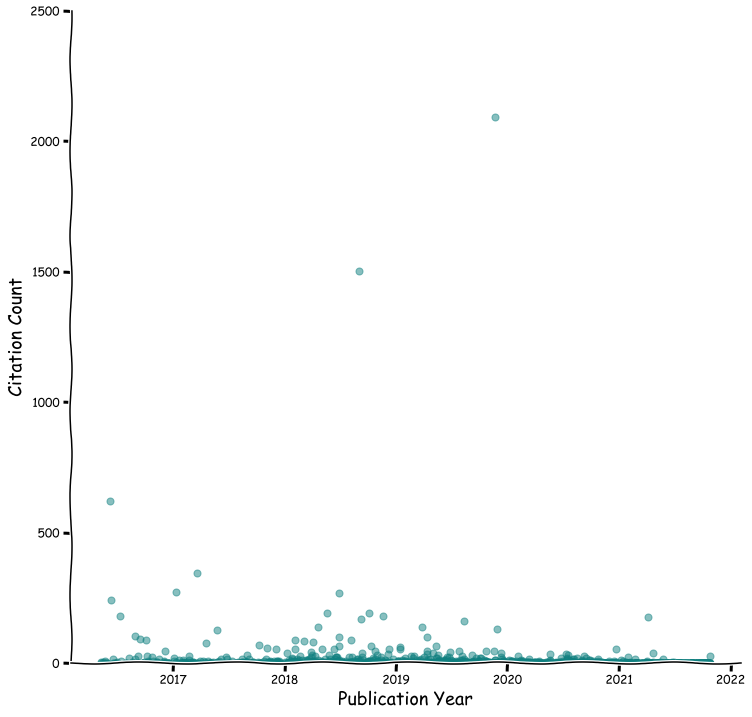

In [396]:
def scatterplot(df, x_dim, y_dim):
  x = df[x_dim]
  y = df[y_dim]
  fig, ax = plt.subplots(figsize=(12, 12))

  #defining an array of colors  
  colors = ['#108080']

  #customizes alpha for each dot in the scatter plot
  ax.scatter(x, y, s=50, alpha=0.50, color=colors)
    
  #adds axes labels
  ax.set_xlabel('Publication Year', fontsize=18)
  ax.set_ylabel('Citation Count', fontsize=18)

  ax.set_ylim([0, 2500])
  ax.xaxis.set_tick_params(labelsize=12)
  ax.yaxis.set_tick_params(labelsize=12)

  #removing top and right borders
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
    
  plt.show()

with plt.xkcd():
    scatterplot(df, 'published.date-parts', 'is-referenced-by-count')

https://api.eventdata.crossref.org/v1/events?mailto=info@front-matter.io&obj-id.prefix=10.21105&source=twitter&rows=0
Event Data query started...
API query complete  200
output file written to 10.21105/ced.json
7348 events found
https://api.eventdata.crossref.org/v1/events?mailto=info@front-matter.io&obj-id.prefix=10.21105&source=wikipedia&rows=0
Event Data query started...
API query complete  200
output file written to 10.21105/ced.json
1842 events found
https://api.eventdata.crossref.org/v1/events?mailto=info@front-matter.io&obj-id.prefix=10.21105&source=datacite&rows=0
Event Data query started...
API query complete  200
output file written to 10.21105/ced.json
941 events found
https://api.eventdata.crossref.org/v1/events?mailto=info@front-matter.io&obj-id.prefix=10.21105&source=hypothesis&rows=0
Event Data query started...
API query complete  200
output file written to 10.21105/ced.json
3 events found
https://api.eventdata.crossref.org/v1/events?mailto=info@front-matter.io&obj-id.pr

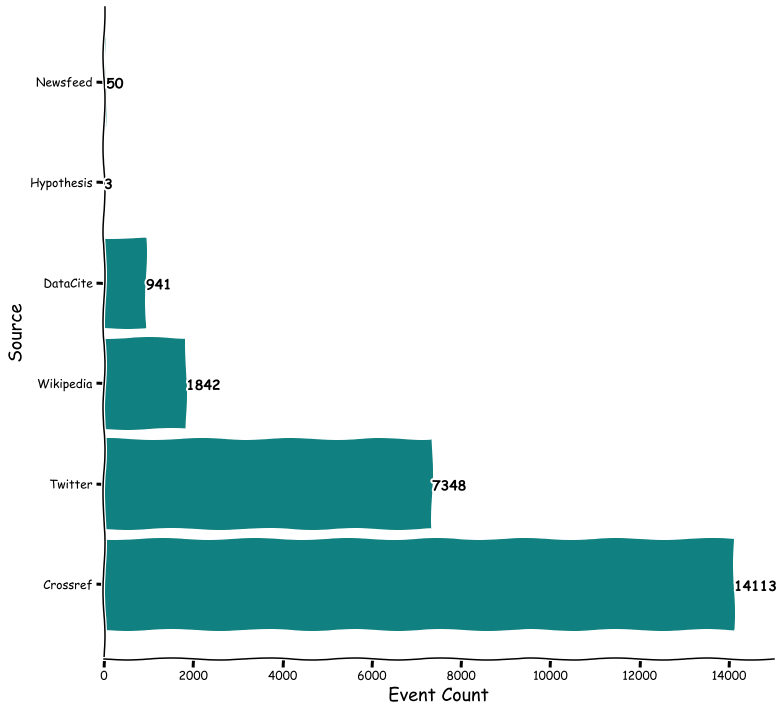

In [397]:
sources = ['Twitter', 'Wikipedia', 'DataCite', 'Hypothesis', 'Newsfeed']
results = [{ 'source': 'Crossref', 'count': df['is-referenced-by-count'].sum()}]

ed = mrced2.eventData(mailto = email)
for source in sources:
    ed.buildQuery({'obj-id.prefix' : prefix, 'source': source.lower(), 'rows': 0})
    ed.runQuery(retry = 5)
    hits = copy.deepcopy(ed.events.getHits())
    pages = math.ceil(hits / 1000)
    results.append({ 'source': source, 'count': hits})

data = pd.DataFrame(results, columns=['source', 'count'])
bars = alt.Chart(data).mark_bar(color='#108080').encode(
    x=alt.X('count:Q', axis=alt.Axis(title='Event count')),
    y=alt.Y('source:O', axis=alt.Axis(title=None))
)
text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='count:Q'
)
(bars + text).properties(height=200,width=700).configure_title(
    fontSize=18
).configure_axis(
    grid=False,
    labelFontSize=18,
    titleFontSize=18
).configure_view(
    strokeWidth=0
)

def barchart(df, x_dim, y_dim):
  x = df[x_dim]
  y = df[y_dim]
  fig, ax = plt.subplots(figsize=(12, 12))

  #defining an array of colors  
  colors = ['#108080']

  #customizes alpha for each dot in the scatter plot
  ax.barh(x, y, height=0.9, color=colors)
    
  #adds axes labels
  ax.set_xlim([0, 15000])
  ax.set_xlabel('Event Count', fontsize=18)
  ax.set_ylabel('Source', fontsize=18)

  ax.xaxis.set_tick_params(labelsize=12)
  ax.yaxis.set_tick_params(labelsize=12)

  #removing top and right borders
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  # show values next to bars
  for i, v in enumerate(y):
      ax.text(v + 3, i - .065, str(v), fontweight='bold')
    
  plt.show()

with plt.xkcd():
    barchart(data, 'source', 'count')

Initialisation to look at the properties of the results.